<a href="https://colab.research.google.com/github/egafdharmawan/Customer-Churn/blob/main/Customer_Churn_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

A company would like to know where and why the customer is churning to other company services. With churn rate in 20%, company need to find a way to keep customer loyal.

# Library

In [ ]:
!pip install dalex
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
import dalex as dx
import scikitplot as skplt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

# Dataset

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/egafdharmawan/Dataset/main/Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Preprocessing

Drop row number, customerID, and surname since we don't use those to predict

In [ ]:
data = data.drop(["CustomerId","RowNumber","Surname"], axis = 1)

Change all categorical features to numeric for modelling purpose

In [ ]:
data['Gender'].replace(['Male','Female'],[0,1],inplace=True)
data['Geography'].replace(['France','Spain','Germany'],[0,1,2],inplace=True)

Check Data distribution

In [ ]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Since the data is imbalance, these value will be used as parameter class weight in modelling.

## Train Test Split

In [ ]:
X = data.drop(['Exited'], axis=1)
Y = data['Exited']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=1000)

In [ ]:
X_train['Exited'] = Y_train

In [ ]:
X_train['Exited'].value_counts(normalize=True)

0    0.79625
1    0.20375
Name: Exited, dtype: float64

After spliting the dataset, distribution of target value in train data is the exact same as the dataset. Let's find all the insight from the data in EDA step.

# EDA

Let's learn the correlation between each features and target variable.

In [ ]:
data.corr()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.008267,0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Geography,0.008267,1.000000,0.016936,0.048092,0.001418,0.348700,-0.006180,0.004036,-0.012692,0.007382,0.153771
Gender,0.002857,0.016936,1.000000,0.027544,-0.014733,-0.012087,0.021859,-0.005766,-0.022544,0.008112,0.106512
Age,-0.003965,0.048092,0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,0.001418,-0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.348700,-0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.006180,0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,0.004036,-0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,-0.012692,-0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,0.007382,0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


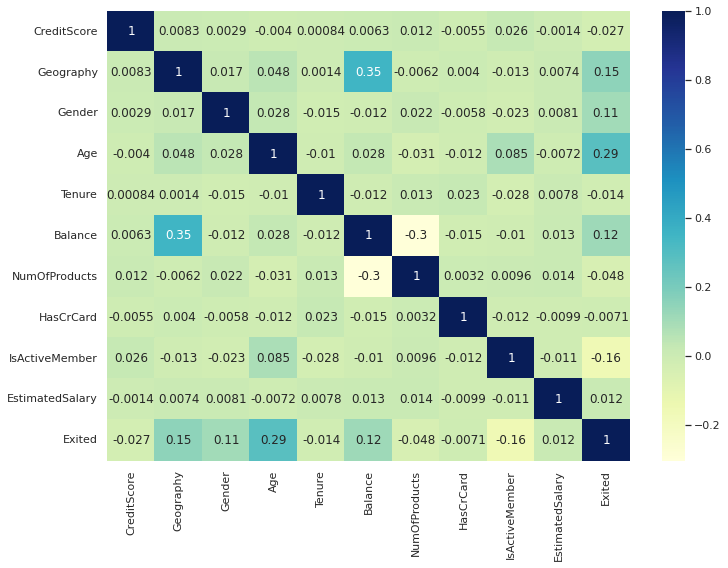

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")

From this heatmap visual, we can see that there is no multicolinearity within the data.

## Categorical Data

**Geography VS Churn**

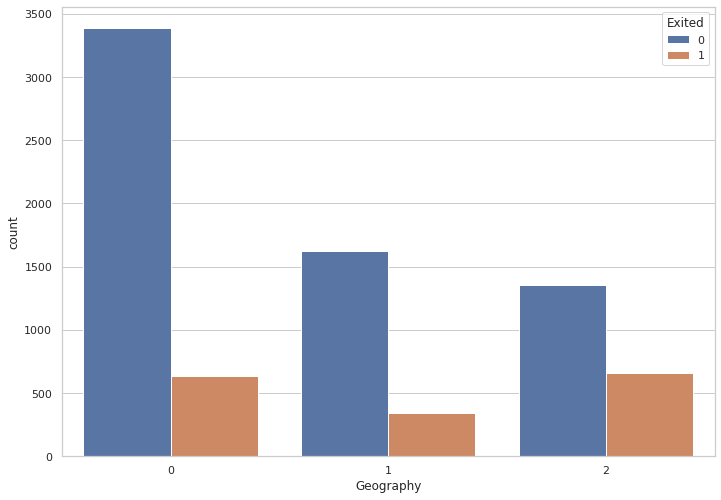

In [ ]:
# 1=France, 2=Spain, 3=Germany
sns.countplot(data=X_train, x="Geography", hue="Exited")

From geography, most churn customer come from germany, churn rate is pretty high compare to all germany customer (around 50%), while loyal customer live in france, france churn is not to high as well, might be good investment. Spain is also looking good with lowest churn customer than any other country, if we treated them well, it might increase number of loyal customer from spain.

**Gender VS Churn**

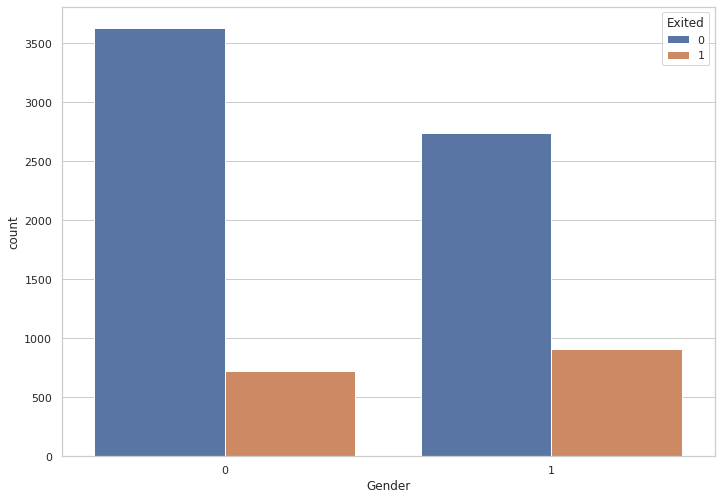

In [ ]:
sns.countplot(data=X_train, x="Gender", hue="Exited")

Based on gender, male customer has higher rate of churn than female customer. Female customer has high amount of user, while churn customer is not that much, this might be what the company need to focus on.

**Has Credit Card VS Churn**

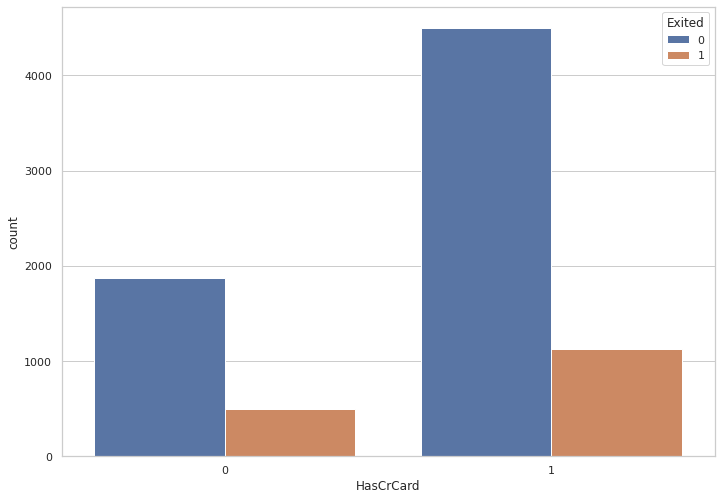

In [ ]:
sns.countplot(data=X_train, x="HasCrCard", hue="Exited")

While customer with credit card is suppose to make transaction easier, seem like it also increase their option in trying some other company service. This user has a higher churn user than those who don't have credit card.

**Is Active Member VS Churn**

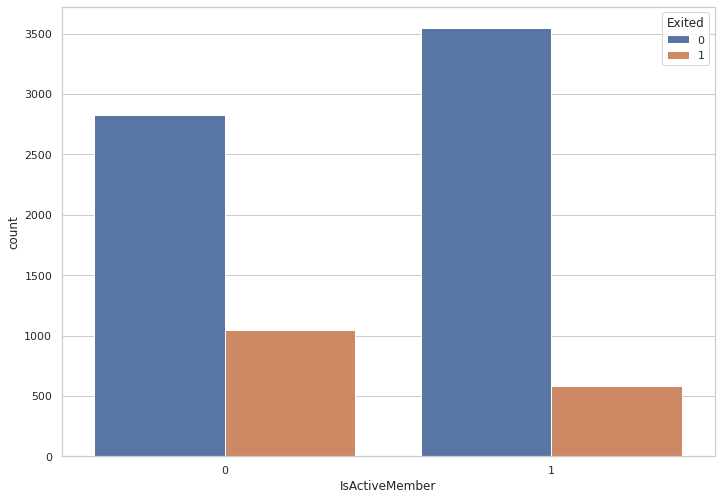

In [ ]:
sns.countplot(data=X_train, x="IsActiveMember", hue="Exited")

This active member must be one way to increase user engagement, there must be some benefit given to this customer. Does it have any effect ? Based on the chart, we know that this treatment has decrease the churn rate pretty well compare to those who are not in active member.

**Number Of Products VS Churn**

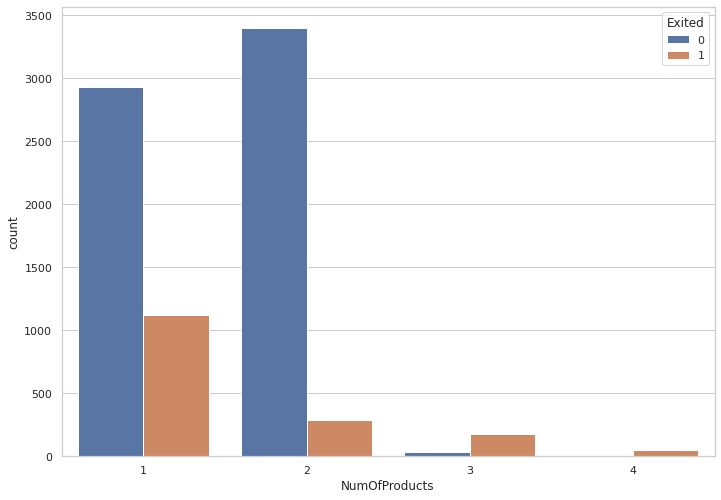

In [ ]:
sns.countplot(data=X_train, x="NumOfProducts", hue="Exited")

The company provide their customer with a few products the can choose, and these are the chart. Customer with 2 products shown that they trust our company, the churn rate is pretty low. While use with 1 product, they just try out of curiosity, and around 30% of these user are not satisfied. User with 3 or more product are most likely to churn, this is weird because when they don't trust the service, why bother getting so many products.

## Numerical Data

**Credit Score VS Churn**

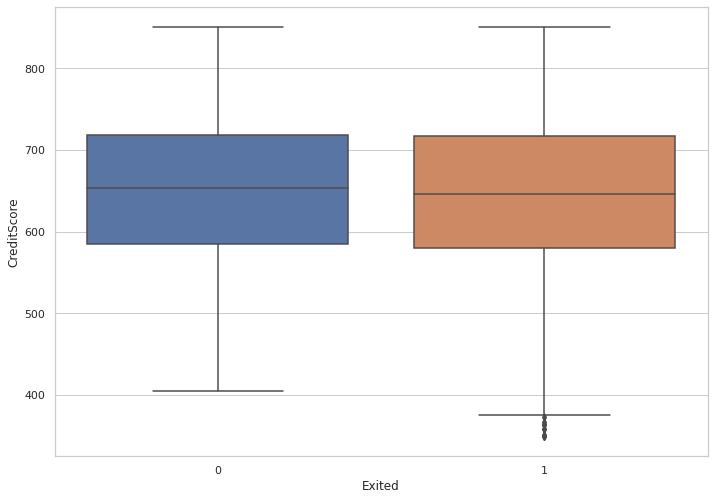

In [ ]:
sns.boxplot(x="Exited", y="CreditScore", data=X_train)

These credit score is applied to customer, the more they engage or purchase the service, the higher the score. In this case, there don't seem to be any difference between churn and non churn user in their credit score distribution. Though churn user has lower median than non churn.

**Age VS Churn**

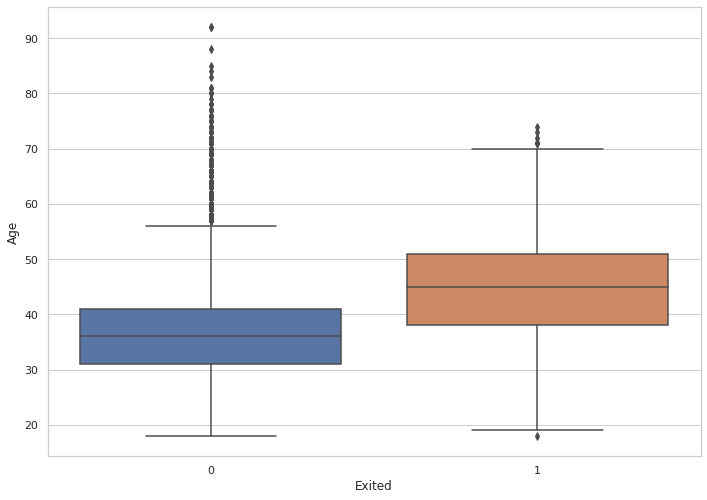

In [ ]:
sns.boxplot(x="Exited", y="Age", data=X_train)

Customer in age between 40 to 50 are most likely to churn, while younger customer decide to trust our products. There is also few older customer prefer to stay with our products.

**Tenure VS Churn**

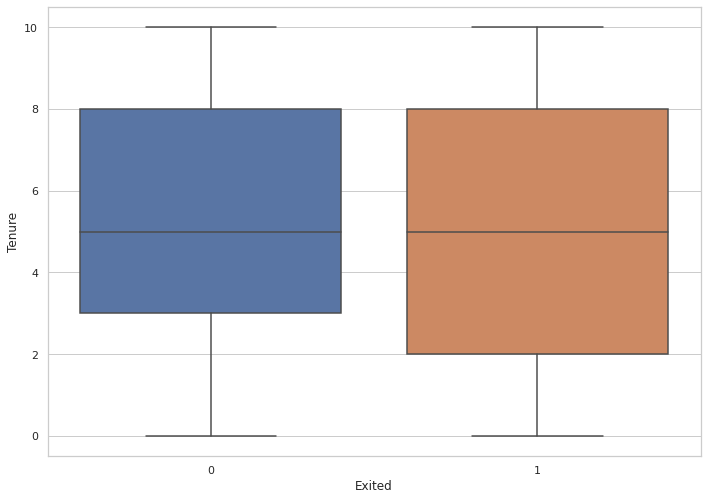

In [ ]:
sns.boxplot(x="Exited", y="Tenure", data=X_train)

Now this is interesting, usually customer with higher tenure tend to stay, but this distribution has the same median. Churn customer has lower q1 which make sense.

**Balance VS Churn**

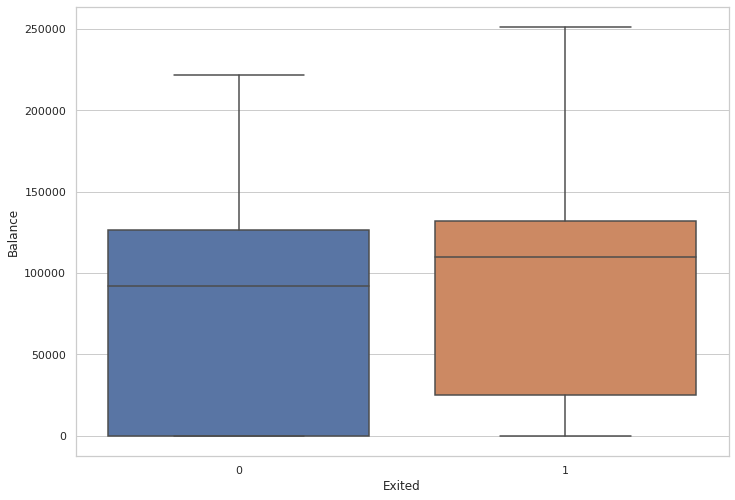

In [ ]:
sns.boxplot(x="Exited", y="Balance", data=X_train)

Customer balance they store in our company, customer with higher balance tend to churn. This is big problem, we need to find a way to treat this customer. While customer with lower balance stay, do they feel safe with our service or just don't want to take a risk..

**Estimated Salary VS Churn**

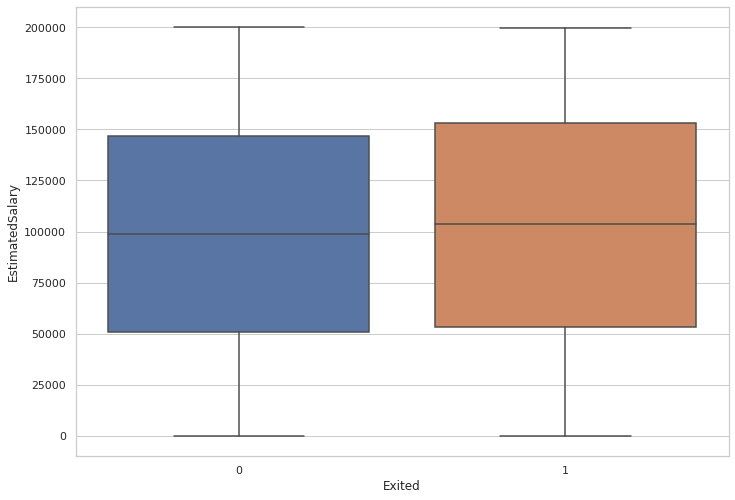

In [ ]:
sns.boxplot(x="Exited", y="EstimatedSalary", data=X_train)

This is the estimated salary of the customer, customer with higher salary tend to churn, though it may not significanly difference than non churn user, we need to fix this.

In [ ]:
# Lest drop the target feature from train data
X_train = X_train.drop(["Exited"], axis = 1)

In [ ]:
Y_test.value_counts()

0    1593
1     407
Name: Exited, dtype: int64

# Modelling

In modelling we will be using 4 model for classification, there are Decision Tree, Random Forest, SVM and XGBoost.

**Decision Tree**

In [ ]:
dc_clf = DecisionTreeClassifier(
    max_depth = 5,
    ccp_alpha = 0.001,
    class_weight = {0: 0.2037, 1:0.7963}
)

In [ ]:
dc_clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight={0: 0.2037, 1: 0.7963},
                       max_depth=5)

**Random Forest**

In [ ]:
rf_clf = RandomForestClassifier(
    random_state=1000,
    n_estimators=1000,
    class_weight = {0: 0.2037, 1:0.7963}
)

In [ ]:
rf_clf.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 0.2037, 1: 0.7963}, n_estimators=1000,
                       random_state=1000)

**SVM RBF**

In [ ]:
svm_clf = SVC(
    random_state = 1000,
    probability=True,
    class_weight = {0: 0.2037, 1:0.7963}
)

In [ ]:
svm_clf.fit(X_train, Y_train)

SVC(class_weight={0: 0.2037, 1: 0.7963}, probability=True, random_state=1000)

**XGBoost**

In [ ]:
xgb_clf = XGBClassifier(
    random_state=1000,
    n_estimators=1000,
    class_weight = {0: 0.2037, 1:0.7963}
)

In [ ]:
xgb_clf.fit(X_train, Y_train)

XGBClassifier(class_weight={0: 0.2037, 1: 0.7963}, n_estimators=1000,
              random_state=1000)

## Model Performance

In [ ]:
# decision tree prediction
dc_pred = dc_clf.predict(X_test)
dc_pred_proba = dc_clf.predict_proba(X_test)

# random forest prediction
rf_pred = rf_clf.predict(X_test)
rf_pred_proba = rf_clf.predict_proba(X_test)

# SVM RBF prediction
svm_pred = svm_clf.predict(X_test)
svm_pred_proba = svm_clf.predict_proba(X_test)

# XGBoost prediction
xgb_pred = xgb_clf.predict(X_test)
xgb_pred_proba = xgb_clf.predict_proba(X_test)

**Decision Tree Result**

In [ ]:
pd.DataFrame(metrics.classification_report(Y_test, dc_pred, target_names=['Not Churn','Churn'], output_dict=True))

,Not Churn,Churn,accuracy,macro avg,weighted avg
precision,0.929567,0.446328,0.7585,0.687947,0.831227
recall,0.753923,0.776413,0.7585,0.765168,0.758500
f1-score,0.832582,0.566816,0.7585,0.699699,0.778499
support,1593.000000,407.000000,0.7585,2000.000000,2000.000000


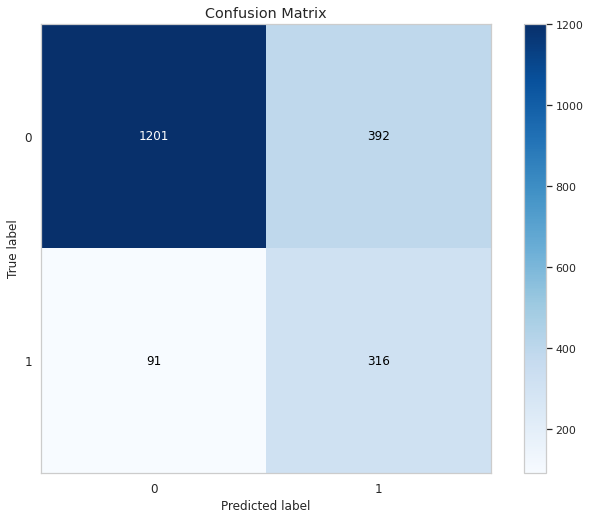

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, dc_pred);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



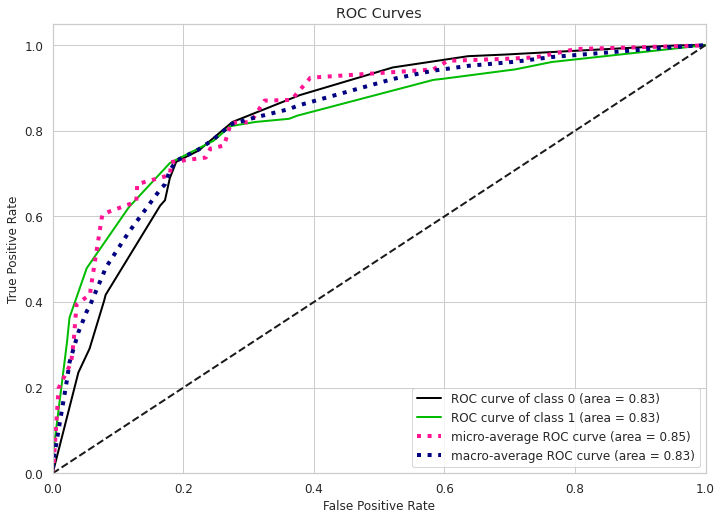

In [ ]:
skplt.metrics.plot_roc_curve(Y_test, dc_pred_proba);

**Result**

Decision Tree perform quite well with 75% accuracy, since the goal of this project is to find the churn customer, hence we will focus on class 1. Decision Tree ROC in 83 % and F1 Score in 56.6%. Let's compare with other models.

**Random Forest Result**

In [ ]:
pd.DataFrame(metrics.classification_report(Y_test, rf_pred, target_names=['Not Churn','Churn'], output_dict=True))

,Not Churn,Churn,accuracy,macro avg,weighted avg
precision,0.871882,0.766949,0.8595,0.819416,0.850528
recall,0.965474,0.444717,0.8595,0.705096,0.859500
f1-score,0.916294,0.562986,0.8595,0.739640,0.844396
support,1593.000000,407.000000,0.8595,2000.000000,2000.000000


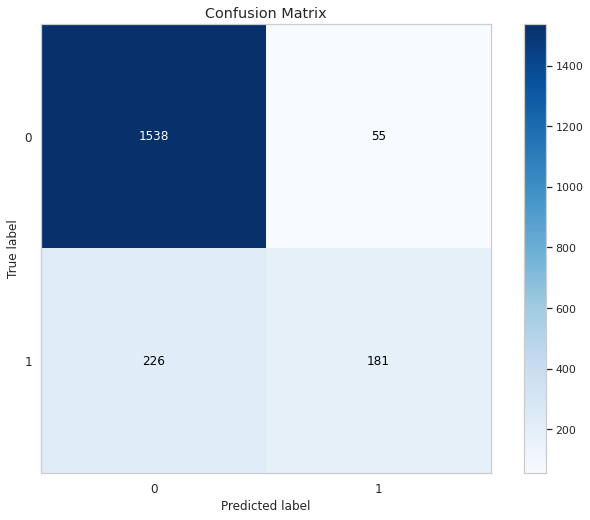

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, rf_pred);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



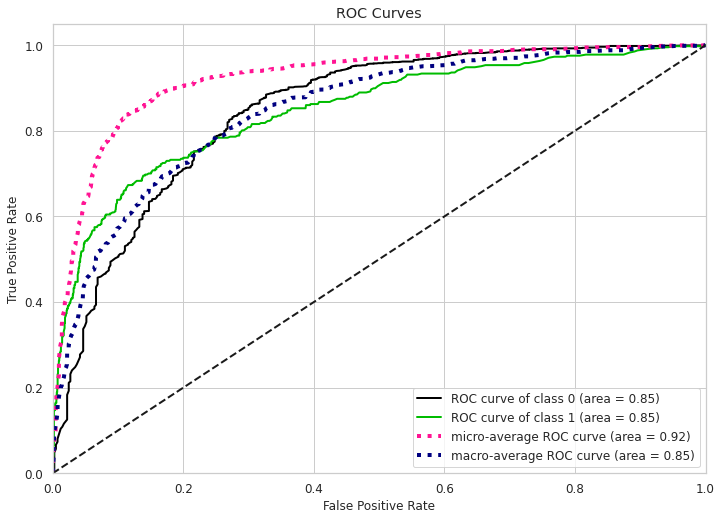

In [ ]:
skplt.metrics.plot_roc_curve(Y_test, rf_pred_proba);

**Result**

Random forest, perform better in accuracy, scoring 85%. ROC of the class 1 is better than Decision Tree as well, in 85%. But this model has less F1 score than Decision Tree, in 56,2%. Not big difference in F1 score.

**SVM RBF Result**

In [ ]:
pd.DataFrame(metrics.classification_report(Y_test, svm_pred, target_names=['Not Churn','Churn'], output_dict=True))

,Not Churn,Churn,accuracy,macro avg,weighted avg
precision,0.865753,0.243307,0.4705,0.554530,0.739086
recall,0.396736,0.759214,0.4705,0.577975,0.470500
f1-score,0.544124,0.368515,0.4705,0.456320,0.508388
support,1593.000000,407.000000,0.4705,2000.000000,2000.000000


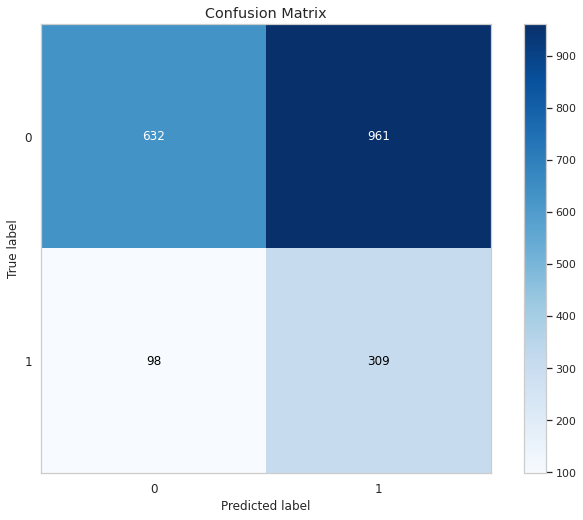

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, svm_pred);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



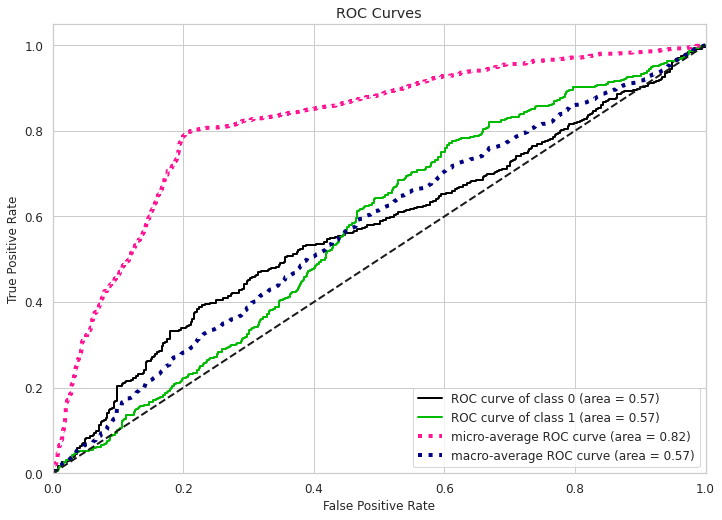

In [ ]:
skplt.metrics.plot_roc_curve(Y_test, svm_pred_proba);

**Result**

SVM perform really bad, maybe the worst model in this case with 47% accuracy. ROC in 57% and F1 Score in 36%. SVM is clearly not an option.

**XGBoost Result**

In [ ]:
pd.DataFrame(metrics.classification_report(Y_test, xgb_pred, target_names=['Not Churn','Churn'], output_dict=True))

,Not Churn,Churn,accuracy,macro avg,weighted avg
precision,0.876163,0.692857,0.8505,0.784510,0.838860
recall,0.946014,0.476658,0.8505,0.711336,0.850500
f1-score,0.909749,0.564774,0.8505,0.737262,0.839547
support,1593.000000,407.000000,0.8505,2000.000000,2000.000000


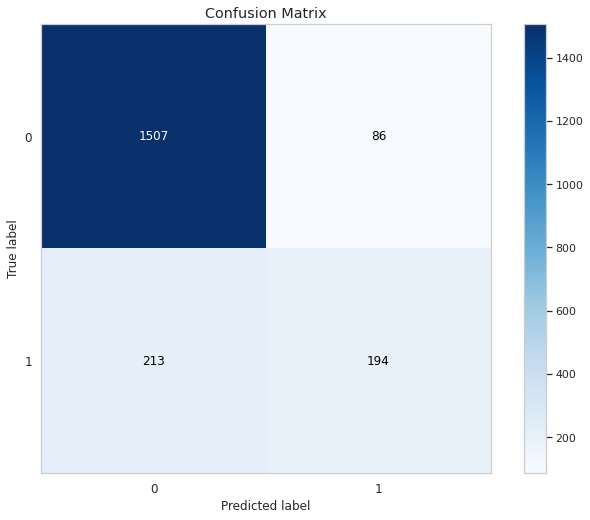

In [ ]:
skplt.metrics.plot_confusion_matrix(Y_test, xgb_pred);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



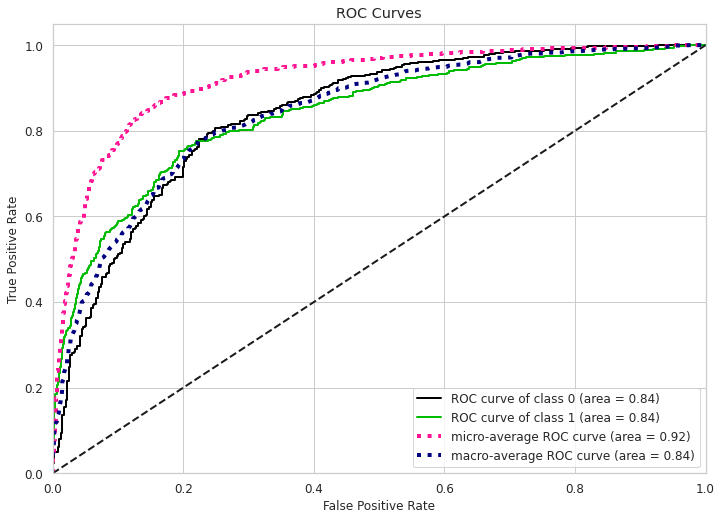

In [ ]:
skplt.metrics.plot_roc_curve(Y_test, xgb_pred_proba);

**Result**

XGBoost has a high accuracy like random forest, scoring in 85%. With ROC of class 1 in 84%, and F1 Score of class 1 in 56,4%.

### Overall Result

Based on overall result, i believe decision tree perform better than any other models. The accuracy may not to high (75%), but considering this dataset is highly imbalance, F1 score is also important. Decision Tree has the highest F1 Score than any other models, this argument is strongly back up by the confusion matrix showing from 400 churn customer in test data, decision tree make 316 correct prediction. It's a high score. Thus we conclude that decision tree is the best model for this case.

## Model Diagnose

Since Decision Tree perform well, we only need to check the reasoning behind Decision Tree model.

In [ ]:
# Inititate Explainer for all models

churn_dc_exp = dx.Explainer(dc_clf, X_train, Y_train, label = "DC Interpretation")

Preparation of a new explainer is initiated

  -> data              : 8000 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 8000 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : DC Interpretation
  -> predict function  : <function yhat_proba_default at 0x7efc1588d170> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.06, mean = 0.389, max = 0.993
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.993, mean = -0.185, max = 0.94
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 8000 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a nu

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



  -> predicted values  : min = 0.14, mean = 0.204, max = 0.254
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.249, mean = -0.000253, max = 0.86
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 8000 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 8000 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RF Interpretation
  -> predict function  : <function yhat_proba_default at 0x7efc1588d170> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



  -> predicted values  : min = 0.0, mean = 0.202, max = 0.991
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.353, mean = 0.00206, max = 0.393
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 8000 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 8000 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGB Interpretation
  -> predict function  : <function yhat_proba_default at 0x7efc1588d170> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 7.79e-05, mean = 0.204, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : differe

### Feature Importance

In [ ]:
churn_dc_exp.model_parts().plot()

**Interpretation**

Decision Tree make age as the most important feature of all. Followed by number of products, and balance in third place. This is what the train data show us earlier in EDA. Looking back at the EDA section, age is the only one showing the clear difference between class 0 and 1, number of product is also gave us the idea of how many product bought will make customer churn. Below are the EDA of Age and Number of Product for further refrence.

**Age VS Churn**

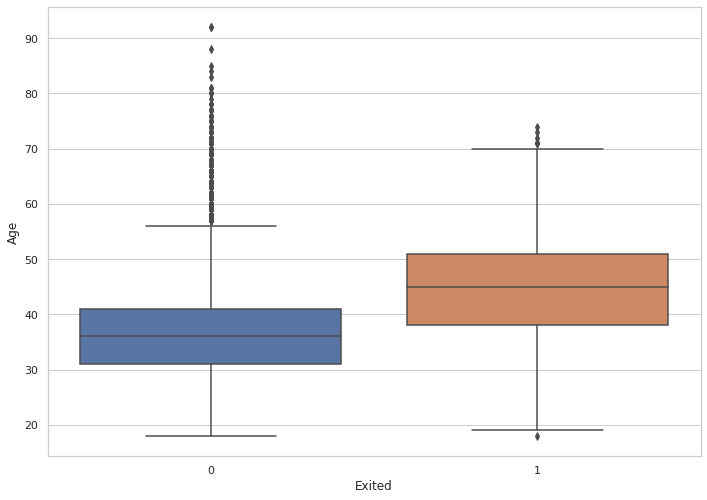

In [ ]:
sns.boxplot(x="Exited", y="Age", data=X_train)

**Number Of Products VS Churn**

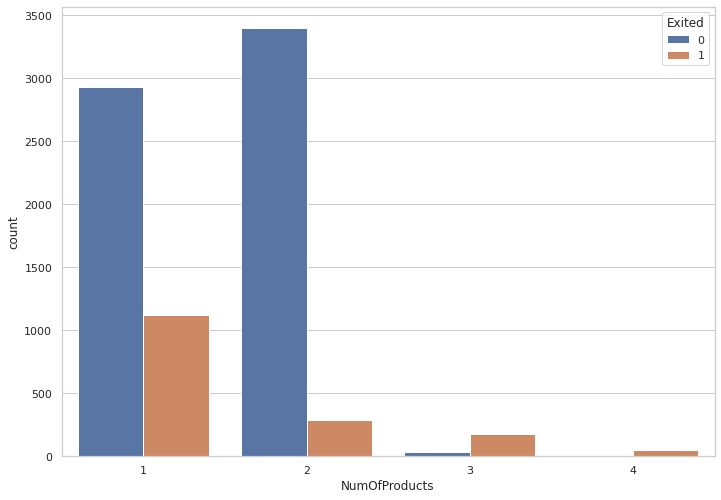

In [ ]:
sns.countplot(data=X_train, x="NumOfProducts", hue="Exited")

### Partial Dependence Plot

In [ ]:
churn_dc_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 10/10 [00:00<00:00, 93.17it/s]


**Interpretation**

In this part, since we know that decision tree said the most important feature is age and number of product. Let's only cover those two, the other seem to be less important features.

A. Age

The diagram clearly show there is an increase of churn possibility in age 40 to 65, while younger poeple is almost loyal to our product. On the other side, customer with age older than 65 seem to have 60 percent of churn possibility.

B. Number Of Products

The diagram tell us when customer bought 1 product, they more stable (50%) churn, but when they get 2 products, the possibility decrease quite much, this happen because we get more non churn customer in the same category. And when they get 3 or more product, the churn possibility become almost 100%.

# Conclusion

After the process of modelling, we used Decision Tree as final model for this case. Perform really well to find the pattern of most likely churn customer. With this model, user can come up with a strategy to treat this spesific customer so they can become loyal.

All those facts state in diagnose section is exactly the same with the EDA we perform earlier. This is safe to say that our models is already good enough and ready for deployment.